# Import libraries

In [189]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from IPython.display import Markdown

# Step 1: Load the data

In [191]:
df = pd.read_excel('Online Retail.xlsx')

# Step 2: Understand the data

In [193]:
print("First 5 rows:", df.head())

First 5 rows:   InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  


In [194]:
print("\nData Info:")
df.info()


Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [195]:
print("\nDescriptive Statistics:\n", df.describe())


Descriptive Statistics:
             Quantity                    InvoiceDate      UnitPrice  \
count  541909.000000                         541909  541909.000000   
mean        9.552250  2011-07-04 13:34:57.156386048       4.611114   
min    -80995.000000            2010-12-01 08:26:00  -11062.060000   
25%         1.000000            2011-03-28 11:34:00       1.250000   
50%         3.000000            2011-07-19 17:17:00       2.080000   
75%        10.000000            2011-10-19 11:27:00       4.130000   
max     80995.000000            2011-12-09 12:50:00   38970.000000   
std       218.081158                            NaN      96.759853   

          CustomerID  
count  406829.000000  
mean    15287.690570  
min     12346.000000  
25%     13953.000000  
50%     15152.000000  
75%     16791.000000  
max     18287.000000  
std      1713.600303  


In [196]:
print("\nMissing Values:\n", df.isnull().sum())


Missing Values:
 InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


# Step 3: Clean the data

In [198]:
# Drop rows with missing CustomerID or Description
df.dropna(subset=['CustomerID', 'Description'], inplace=True)


In [199]:
# Remove duplicates
df.drop_duplicates(inplace=True)

In [200]:
# Remove negative or zero Quantity or UnitPrice
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]


In [247]:
# Remove cancelled orders (InvoiceNo starting with 'C')
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]


In [249]:
df['CustomerID'] = df['CustomerID'].astype(int)


# Step 4: Feature Engineering 

In [202]:
# TotalAmount per transaction
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

In [251]:
# Aggregate data by CustomerID
customer_df = df.groupby('CustomerID').agg({
    'InvoiceNo': 'nunique',
    'Quantity': 'sum',
    'TotalAmount': 'sum',
    'InvoiceDate': ['min', 'max'],
    'Country': 'first'
}).reset_index()

In [253]:
# Rename columns
customer_df.columns = ['CustomerID', 'NumOrders', 'TotalQuantity', 'TotalSpent', 'FirstPurchase', 'LastPurchase', 'Country']



In [255]:
# Recency (days since last purchase)
latest_date = df['InvoiceDate'].max()
customer_df['Recency'] = (latest_date - customer_df['LastPurchase']).dt.days

# Step 5. Data Preparation for Clustering

In [258]:
# Drop non-numeric or ID columns for clustering
clustering_df = customer_df[['NumOrders', 'TotalQuantity', 'TotalSpent', 'Recency']]


# Step 6: Feature Scaling

In [261]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(clustering_df)

# Step 7: Elbow Method to find optimal k

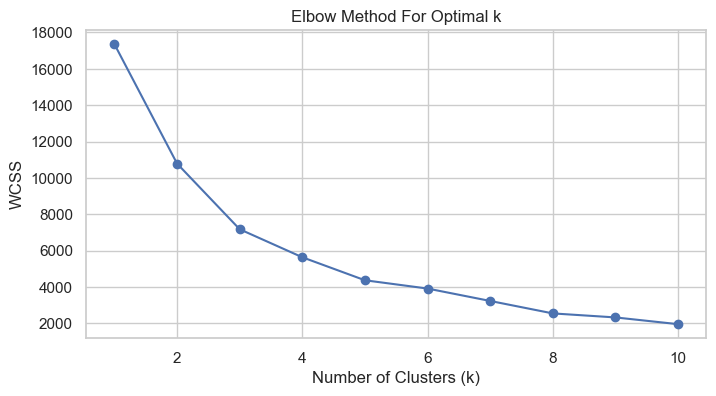

In [264]:
wcss = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 4))
plt.plot(K, wcss, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method For Optimal k')
plt.show()

# Step 8: K-Means Clustering


In [267]:
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_features)


In [269]:
# Add cluster info to the original customer_df
customer_df['Cluster'] = cluster_labels

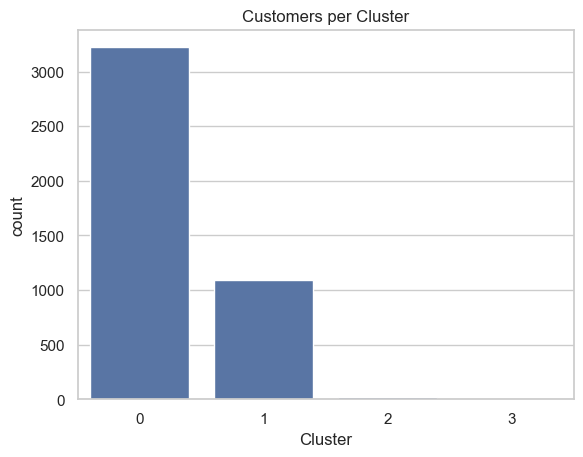

In [271]:
sns.countplot(x='Cluster', data=customer_df)
plt.title('Customers per Cluster')
plt.show()

# Step 9: PCA for Visualization


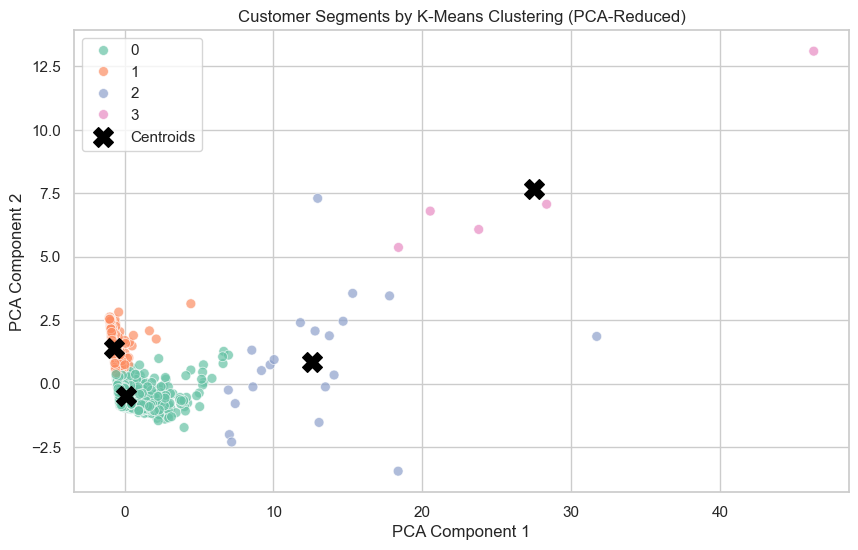

In [274]:
# Enhanced PCA scatterplot with cluster centers
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced_features[:, 0], y=reduced_features[:, 1], hue=cluster_labels, palette='Set2', s=50, alpha=0.7)
centroids_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], s=200, c='black', marker='X', label='Centroids')
plt.title('Customer Segments by K-Means Clustering (PCA-Reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.show()


# Step 10: Cluster Summary

In [277]:
# Cluster summary
cluster_summary = customer_df.groupby('Cluster').agg({
    'NumOrders': 'mean',
    'TotalQuantity': 'mean',
    'TotalSpent': 'mean',
    'Recency': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'NumCustomers'})

print(cluster_summary)

         NumOrders  TotalQuantity     TotalSpent     Recency  NumCustomers
Cluster                                                                   
0         4.686220    1102.613904    1873.131804   40.171633          3222
1         1.579817     284.293578     558.239799  245.136697          1090
2        71.857143   38100.809524   57897.890476   20.095238            21
3        40.400000   97876.600000  205528.228000    6.200000             5


# Step 11: Cluster Interpretation Summary



**Cluster 0 — Regular/Mid-Tier Customers (3222 Customers)**
- **Profile:** Moderate recency, moderate order frequency, moderate spend.
- **Behavior:** Reliable and consistent, they form the backbone of your customer base.
- **Strategy:** Maintain engagement through routine promotions, tailored recommendations, and loyalty point systems.

**Cluster 1 — Inactive/Churned Customers (1090 Customers)**
- **Profile:** High days since last purchase (low recency), low spend, low frequency.
- **Behavior:** Likely one-time or lapsed buyers.
- **Strategy:** Reactivation campaigns with discounts, reminders, or surveys to understand churn reasons.

**Cluster 2 — Loyal High-Value Customers (21 Customers)**
- **Profile:** Recent purchases, very high spend, high frequency.
- **Behavior:** VIP customers contributing heavily to revenue.
- **Strategy:** Prioritize with loyalty tiers, early access, exclusive products, and personal outreach.

**Cluster 3 — Top Tier/Wholesale Clients (5 Customers)**
- **Profile:** Very recent purchases, extremely high quantity and spend, high frequency.
- **Behavior:** Likely B2B or top 1% customers.
- **Strategy:** Custom pricing, dedicated account reps, and priority fulfillment to strengthen relationship.
